In [56]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=160)
np.random.seed(42)

In [57]:
population_per_age = 1000
max_age = 50
num_years = 50

# susceptible in age group in year
SI_out = np.zeros((num_years+1, max_age+1, 3))

# Initial first year
SI_out[0, :, 0] = population_per_age
# 100 Births every year
SI_out[:, 0, 0] = population_per_age

lamb = 0.1
lamb_by_year = np.random.uniform(0.05, 0.15, num_years)
lamb_by_year_and_age = np.repeat(lamb_by_year.reshape(1, -1), max_age, axis=0)

In [58]:
lamb_by_year_and_age

array([[0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545],
       [0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545],
       [0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545],
       ...,
       [0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545],
       [0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545],
       [0.08745401, 0.14507143, 0.12319939, ..., 0.1020068 , 0.10467103, 0.06848545]])

In [59]:
for y_num in range(num_years):
    for a_num in range(max_age):
        curr_susceptible = SI_out[y_num, a_num, 0]
        curr_infection = SI_out[y_num, a_num, 1]

        # TODO: fix this
        # curr_lamb = lamb
        curr_lamb = min(lamb_by_year_and_age[y_num, a_num], 1)

        created_infections = curr_susceptible * curr_lamb

        new_susceptible = curr_susceptible - created_infections
        new_infection = curr_infection + created_infections

        # Issue with the + 1 for the last index
        SI_out[y_num + 1, a_num + 1, 0] = new_susceptible
        SI_out[y_num + 1, a_num + 1, 1] = new_infection
        SI_out[y_num, a_num, 2] = created_infections
        

In [64]:
SI_out[:, :, 2]

array([[ 87.45401188, 145.07143064, 123.19939418, ..., 104.67102793,  68.48544555,   0.        ],
       [ 87.45401188, 132.38435202, 105.32668181, ...,  93.9938711 ,  61.31700357,   0.        ],
       [ 87.45401188, 132.38435202,  96.11544093, ...,  86.36428447,  55.06225212,   0.        ],
       ...,
       [ 87.45401188, 132.38435202,  96.11544093, ...,   0.8510443 ,   0.54632596,   0.        ],
       [ 87.45401188, 132.38435202,  96.11544093, ...,   0.8510443 ,   0.49854757,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,   0.        ,   0.        ]])

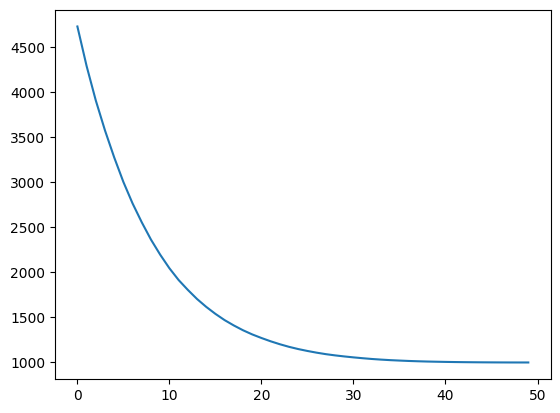

In [61]:
plt.plot(SI_out[:num_years, :max_age, 2].sum(axis=1))
plt.show()